In [2]:
from get_data import create_hdf5
import numpy as np
from PIL import Image
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from typing import List, Tuple
import matplotlib.pyplot as plt
from skimage.transform import resize
from matplotlib import cm as CM
import h5py
import cv2

In [2]:
def generate_label(label_info: np.array, image_shape: List[int]):
    """
    Generate a density map based on objects positions.

    Args:
        label_info: (x, y) objects positions
        image_shape: (width, height) of a density map to be generated

    Returns:
        A density map.
    """
    # create an empty density map
    label = np.zeros(image_shape, dtype=np.float32)

    # loop over objects positions and marked them with 100 on a label
    # note: *_ because some datasets contain more info except x, y coordinates
    for x, y, *_ in label_info:
        if y < image_shape[0] and x < image_shape[1]:
            label[int(y)][int(x)] = 100

    # apply a convolution with a Gaussian kernel
    label = gaussian_filter(label, sigma=(1, 1), order=0)

    return label

In [4]:
def _resize(image, matrix):

    im = Image.open(image)
    w, h = im.size
    im = im.resize((224,224))
    new_pts = np.zeros(matrix.shape)
    for i, pt in enumerate(matrix):
        new_pts[i][0] = pt[0]*(224/w)
        new_pts[i][1] = pt[1]*(224/h)
    
    return im , new_pts

In [26]:
def generate_mall_data():
    """Generate HDF5 files for mall dataset."""
    # download and extract dataset
    #commented by kc
    # get_and_unzip(
    #     'http://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip'
    # )
    # create training and validation HDF5 files
    train_h5, valid_h5 = create_hdf5('mall',
                                     train_size=1500,
                                     valid_size=500,
                                     img_size=(224, 224),
                                     in_channels=3)

    # load labels infomation from provided MATLAB file
    # it is a numpy array with (x, y) objects position for subsequent frames
    labels = loadmat('mall_dataset/mall_gt.mat')['frame'][0]

    def fill_h5(h5, labels, init_frame=0):
        """
        Save images and labels in given HDF5 file.

        Args:
            h5: HDF5 file
            labels: the list of labels
            init_frame: the first frame in given list of labels
        """
        for i, label in enumerate(labels, init_frame):
            # path to the next frame (filename convention: seq_XXXXXX.jpg)
            img_path = f"mall_dataset/frames/seq_{str(i+1).zfill(6)}.jpg"

            # get an image as numpy arrayimport matplotlib.pyplot as plt

            image = np.array(Image.open(img_path).resize((224,224)), dtype=np.float32) / 255
            image = np.transpose(image, (2, 0, 1))

            _, x = _resize(img_path, label[0][0][0])
            # generate a density map by applying a Gaussian filter
            label = generate_label(x, image.shape[1:])
            # save data to HDF5 file
            h5['images'][i - init_frame] = image
            h5['labels'][i - init_frame, 0] = label

    # use first 1500 frames for training and the last 500 for validation
    fill_h5(train_h5, labels[:1500])
    fill_h5(valid_h5, labels[1500:], 1500)

    # close HDF5 file
    train_h5.close()
    valid_h5.close()

In [27]:
generate_mall_data()

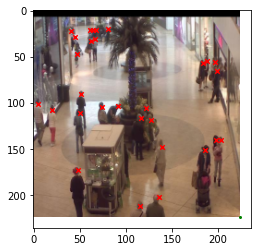

(224, 224)


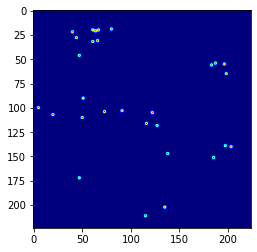

In [24]:
labels = loadmat('mall_dataset/mall_gt.mat')['frame'][0]
for i, label in enumerate(labels, 0):
    img_path = f"mall_dataset/frames/seq_{str(i+1).zfill(6)}.jpg"
    image = plt.imread(img_path)
    _, x = _resize(img_path, label[0][0][0])
    label = generate_label(x, (224,224))

    plt.imshow(resize(image, (224, 224)))
    plt.plot(224, 224, "og", markersize=2)  # og:shorthand for green circle
    plt.scatter(x[:,0], x[:,1], marker="x", color="red", s=20)
    plt.show()

    groundtruth = np.asarray(label)
    print(groundtruth.shape)
    plt.imshow(groundtruth,cmap=CM.jet)
    break

            
    

In [3]:
with h5py.File('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/NWPU_dataset/train.h5', 'r') as f:
    print(f.keys())
    print(type(f['images']))
    images = []
    labels = []
    for i in range(len(f['images'])):
        images.append(f['images'][i])
        labels.append(f['labels'][i])

<KeysViewHDF5 ['images', 'labels']>
<class 'h5py._hl.dataset.Dataset'>


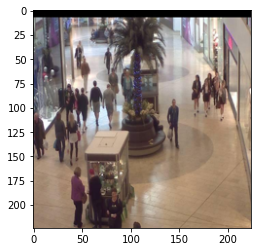

In [10]:
x = np.transpose(images[100], (1, 2, 0))
plt.imshow(x)

(224, 224)


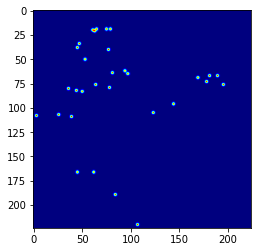

In [11]:
groundtruth = np.asarray(labels[100][0])
print(groundtruth.shape)
plt.imshow(groundtruth,cmap=CM.jet)

In [8]:
with h5py.File('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/mall/train.h5', 'r') as f:
    print(f.keys())
    print(type(f['images']))
    images = []
    labels = []
    for i in range(len(f['images'])):
        images.append(f['images'][i])
        labels.append(f['labels'][i])

<KeysViewHDF5 ['images', 'labels']>
<class 'h5py._hl.dataset.Dataset'>


In [9]:
print(len(images))

1500
